## Table of Contents
* [Goals](#goals)
* [Data](#data)
    * [Loading Data](#section1_1)
    * [Data Information](#section1_2)
* [Data Cleaning](#cleaning)
    * [Categorical Data](#section2_1)
    * [Qauntitative Data](#section2_2)
* [Exploratory Data Analysis](#eda)
    * [Statistics by Make](#section3_1)
    * [Statistics by Dealer](#section3_2)
    * [Statistics by Year](#section3_3)
* [Prediction Using Linear Regression](#linear)
    * [Sampling Distribution](#section4_1)
* [Conclusion](#end)

### Goals <a class="anchor" id="goals"></a>
This notebook contains data scraped from a used truck sales websites. The goal of this is project is to do the following:
* Retrieve our data from webscrapes "wild data"
* Clean the data so it is ready for analysis
* Develop some questions for analysis
* Analyze variables within the data to gain patterns and insights on these questions
* Store data in a database
* Create a [dashboard presentation using Tableau](https://public.tableau.com/app/profile/devan.veach/viz/Used-HD-Truck-Sales/Dashboard)

### Data <a class="anchor" id="data"></a>
The data for this project was gathered using Web Scraper; a free Edge plug-in, from [equiptment experts](https://www.equipmentexperts.com/). This website shows listings for Class A heavy duty equiptment.

remember thse are USED trucks. They are compared to other USED trucks and are NOT compared to new trucks.

#### Loading the Data <a class="anchor" id="section1_1"></a>
We will import the librarys we plan on using and view the first 5 lines of the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
data = pd.read_csv('equiptment_experts_raw_data.csv')
data.head()

,mileage,dealer,location,price,make,website
0,"461,060 mi",Doggett Freightliner,"Pharr, TX","$34,900",2015 Volvo VNL,https://www.equipmentexperts.com/trucking/heav...
1,"391,294 mi",Arrow Truck Sales,"French Camp, CA","$106,950",2020 KENWORTH T680,https://www.equipmentexperts.com/trucking/heav...
2,"476,567 mi",Bonander Truck & Trailer,"Turlock, CA","$88,500",2016 Freightliner Cascadia,https://www.equipmentexperts.com/trucking/heav...
3,"139,319 mi",Dobbs Peterbilt,"North Little Rock, AR","$171,950",2022 PETERBILT 579,https://www.equipmentexperts.com/trucking/heav...
4,"674,852 mi",Truck and Van Outlet,"Miami, FL","$49,995",2012 Kenworth T700,https://www.equipmentexperts.com/trucking/heav...


#### Data Information <a class="anchor" id="section1_2"></a>
some immediate insights are:
* `mileage` is an object and needs to be stripped and converted to a float. There are also some null values and we should investigate values such as "1 mi"
* `location` column can be split to City and State columns
* `price` dtype needs to be converted to a int and although it is not showing any null values there are values like "Call for Price"
* `make` column needs to be split into "year", "make", "model" and formatted
* `website` dtype needs to be html
* `year` needs to be an ordered category


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mileage   8485 non-null   object
 1   dealer    8857 non-null   object
 2   location  8857 non-null   object
 3   price     8857 non-null   object
 4   make      8857 non-null   object
 5   website   8857 non-null   object
dtypes: object(6)
memory usage: 415.3+ KB


In [4]:
data.isnull().sum()

mileage     372
dealer        0
location      0
price         0
make          0
website       0
dtype: int64

In [5]:
data.describe()

,mileage,dealer,location,price,make,website
count,8485,8857,8857,8857,8857,8857
unique,8290,76,498,1694,1299,8857
top,1 mi,Penske Used Trucks,"Covington, TN",Call For Price,2016 FREIGHTLINER X12564ST,https://www.equipmentexperts.com/trucking/heav...
freq,10,2237,804,355,563,1


### Data Cleaning <a class="anchor" id="cleaning"></a>

#### Categorical Data Cleaning <a class="anchor" id="section2_1"></a>

We will start with seperating all our categorical data into their desired columns
* create `year`, `make`, `model` columns
    * 1 issue was with the format 'Navistar'(Parent Company of International) on International trucks that had different format than the rest of the trucks. I first had to remove this in order properly split the columns
* create `city`, `state` columns
* check our makes and drop any makes in the data that are not Class A vehicles

In [6]:
# removing 'Navistar' from makes so that we can split correctly
data['make'] = data['make'].str.title()
data['make'] = data['make'].str.replace('Navistar', '')

# creating new columns and adding the data to them from the make column
data['year'] = data['make'].apply(lambda x: str(x).split()[0])
data['model'] = data['make'].apply(lambda x: ''.join(str(x).split()[2:]))
data['make'] = data['make'].apply(lambda x: str(x).split()[1])

# creating city and state columns and removing location column
data['city'] = data['location'].apply(lambda x: str(x).split(',')[0])
data['state'] = data['location'].apply(lambda x: str(x).split(',')[1])
data.drop(columns='location', axis=1, inplace=True)

#changing website datatype
def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'
data.style.format({'website': make_clickable})


data.head()

,mileage,dealer,price,make,website,year,model,city,state
0,"461,060 mi",Doggett Freightliner,"$34,900",Volvo,https://www.equipmentexperts.com/trucking/heav...,2015,Vnl,Pharr,TX
1,"391,294 mi",Arrow Truck Sales,"$106,950",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2020,T680,French Camp,CA
2,"476,567 mi",Bonander Truck & Trailer,"$88,500",Freightliner,https://www.equipmentexperts.com/trucking/heav...,2016,Cascadia,Turlock,CA
3,"139,319 mi",Dobbs Peterbilt,"$171,950",Peterbilt,https://www.equipmentexperts.com/trucking/heav...,2022,579,North Little Rock,AR
4,"674,852 mi",Truck and Van Outlet,"$49,995",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2012,T700,Miami,FL


In [7]:
print(data.make.unique())

['Volvo' 'Kenworth' 'Freightliner' 'Peterbilt' 'Mack' 'International'
 'Western' 'Sterling' 'Ftl' 'Gmc' 'Ford' 'Autocar' 'Cascadia' 'Isuzu'
 '379' 'Caterpillar' 'Kaiser' 'Ccc' 'Chevrolet' '567' 'Oshkosh' 'Bmy']


a couple of issues arrise:
* not all makes are stricly class A
* some models ended up in our makes '567', 'Cascadia'
* 'Ftl' is a 'Freightliner' and 'Western' is a 'Western Star'

In [8]:
# removed Western from suspect it is not in data anyway and printed too much
suspect_models = ['567', 'Ftl', 'Cascadia', '379']
for model in suspect_models:
    print(data[data['make'] == model])

# 567: missing year, information not provided by website
# Ftl: incorrect model, information not provided by website
# Cascadia: missing year, information not provided by website
# Western: can be fixed, only 'make' with 2 words, Star is part of model

        mileage                dealer     price make   
6927  62,802 mi  Dobbs Peterbilt - WA  $279,999  567  \

                                                website       year model   
6927  https://www.equipmentexperts.com/trucking/heav...  Peterbilt        \

        city state  
6927  Sumner    WA  
        mileage                 dealer    price make   
530  146,647 mi  Southport Truck Group  $39,900  Ftl  \

                                               website  year    model   
530  https://www.equipmentexperts.com/trucking/heav...  2012  Ca125Dc  \

           city state  
530  Fort Myers    FL  
         mileage           dealer    price      make   
2027  731,058 mi  TSI Truck Sales  $73,900  Cascadia  \
2510  725,534 mi  TSI Truck Sales  $74,900  Cascadia   
2518  744,345 mi  TSI Truck Sales  $62,900  Cascadia   
2521  716,361 mi  TSI Truck Sales  $74,900  Cascadia   

                                                website          year model   
2027  https://www.equipm

In [9]:
# removing Star from model and correcting all Western Star makes
data['model'] = data['model'].apply(lambda x: str(x).strip('Star'))
data['make'] = data['make'].apply(lambda x: x + ' Star' if x == 'Western' else x)

#removing all rows that are not a class A vehicle
class_a = ['Volvo', 'Kenworth', 'Freightliner', 'Peterbilt', 'Mack', 'International']
data = data[data['make'].isin(class_a)]
print(data['make'].unique())


['Volvo' 'Kenworth' 'Freightliner' 'Peterbilt' 'Mack' 'International']


We will now work to make the `year` column categorical
* one of the values for `year` is incorrect we will remove that

In [10]:
# getting list of years for categories
years = data['year'].unique()
years

array(['2015', '2020', '2016', '2022', '2012', '2019', '2000', '2017',
       '2018', '2001', '2014', '2008', '2010', '2004', '2005', '2009',
       '2021', '1996', '2013', '2007', '2011', '2006', '1997', '1998',
       '1987', '2023', '2003', '1989', '2002', '2024', '1988', '1993',
       '1995', '1991', '1986', '1994', '1999', '1990', '1985', '1966',
       '1963', '1992', '1982', '1972', '1980', '1979', '1984', '201'],
      dtype=object)

In [11]:
# removing all instances of invalid year using regular expression for 4 digits
data = data[data['year'].apply(lambda x: bool(re.match(r'^\d{4}$', x)))]

# changing year column to an ordered category
data['year'] = pd.Categorical(data['year'], categories=data['year'].unique(), ordered=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8669 entries, 0 to 8856
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   mileage  8337 non-null   object  
 1   dealer   8669 non-null   object  
 2   price    8669 non-null   object  
 3   make     8669 non-null   object  
 4   website  8669 non-null   object  
 5   year     8669 non-null   category
 6   model    8669 non-null   object  
 7   city     8669 non-null   object  
 8   state    8669 non-null   object  
dtypes: category(1), object(8)
memory usage: 619.4+ KB


#### Qantitative Data Cleaning <a class="anchor" id="section2_2"></a>
The `mileage` and `price` column are going to be our main columns for analysis so we need to ensure these are the cleanest we will start by:
* converting all psuedo NaN values to an acutal Nan and then removing them from our dataset
* removing commas and strings from `mileage` and converting them to integers
* removing $ and commas from `price` and converting them to floats

Both columns are then looked at using a boxplot for outliers since we have found some we will explore there merit

In [12]:
# replacing values 'nan' and 'Call For Price' with actual Nan values
data['price'] = data['price'].replace('Call For Price', np.NaN)
data['mileage'] = data['mileage'].replace('nan', np.NaN)

#drop all NaN values from mileage and price
data = data.dropna(how = 'any').reset_index(drop=True)

#spliting strings, removing commas, converting to int64 - (some values were too big we need to investigate)
data['mileage'] = data['mileage'].apply(lambda x: str(x).split(' ')[0].replace(',', '')).astype('int64')
data['price'] = data['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype('float')

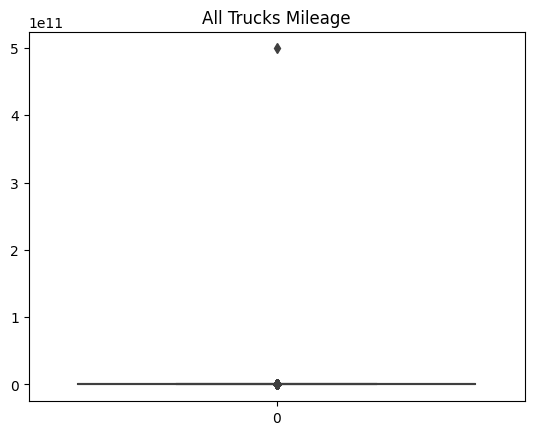

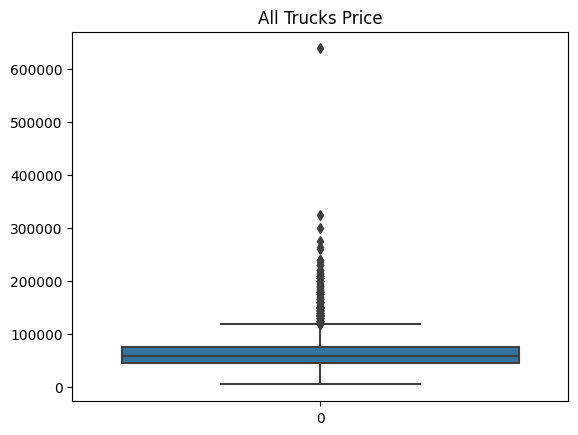

<Figure size 640x480 with 0 Axes>

In [13]:
#plottig boxplot for outlier information
sns.boxplot(data['mileage'])
plt.title('All Trucks Mileage')
plt.show()
plt.clf()
sns.boxplot(data['price'])
plt.title('All Trucks Price')
plt.show()
plt.clf()

There is a significant outlier showing 500 trillion miles- "and on the first day God created a 2018 Volvo VNL" sounds legit right! lets go ahead and remove that from our data

There is also a high amount for a used truck, after exploring this outlier on the below scatter plot compared to vehicles like it, I have determined they must have added an extra 0 when publishing it. The truck is no longer on the website so I cannot verify for sure if maybe this was a heavy haul or possibly an oil field rig either way we are removing it from our dataset

In [14]:
#exploring the outlier for high mileage
high_mileage_truck = data[data['mileage'] > 3000000]
high_mileage_truck

,mileage,dealer,price,make,website,year,model,city,state
846,499113501094,Tri-State Truck Center Inc,85995.0,Volvo,https://www.equipmentexperts.com/trucking/heav...,2018,Vnl64T860,Memphis,TN


In [15]:
#exploring the outlier for high price
high_price_outlier = data[data['price'] > 500000]
data_like_outlier = data[(data['year'] == '2018') & (data['make'] == 'Freightliner') & (data['mileage'].between(550000, 600000))]
high_price_outlier

,mileage,dealer,price,make,website,year,model,city,state
3703,588319,M&K Truck Centers,638400.0,Freightliner,https://www.equipmentexperts.com/trucking/heav...,2018,Cascadia126,Indianapolis,IN


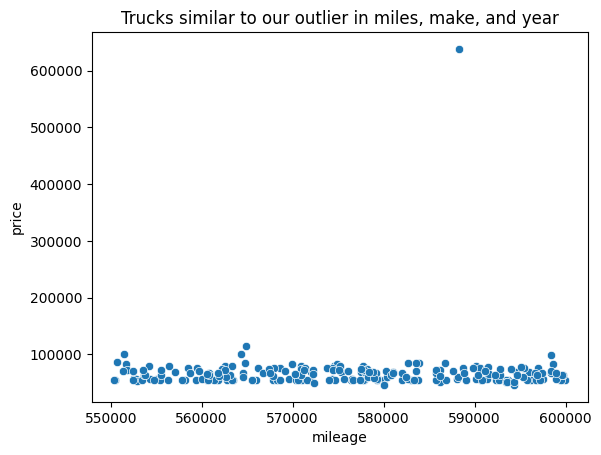

<Figure size 640x480 with 0 Axes>

In [16]:
sns.scatterplot(data_like_outlier, x='mileage', y='price')
plt.title('Trucks similar to our outlier in miles, make, and year')
plt.show()
plt.clf()

Removing outliers from dataset
We will also remove any truck with `mileage` less than 10000 miles as we are exploring used trucks not new trucks this will also clean our data from really high prices of newer trucks

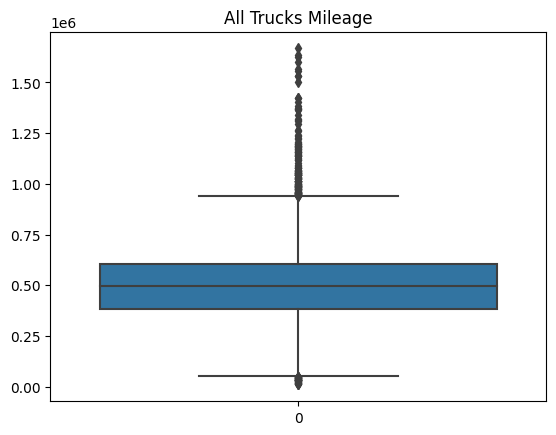

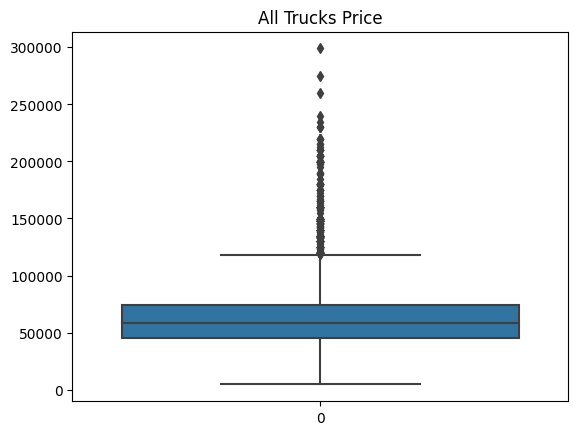

<Figure size 640x480 with 0 Axes>

In [17]:
data = data[data['price'] < 600000]
data = data[data['mileage'].between(10000, 2000000)]

sns.boxplot(data['mileage'])
plt.title('All Trucks Mileage')
plt.show()
plt.clf()
sns.boxplot(data['price'])
plt.title('All Trucks Price')
plt.show()
plt.clf()


In [18]:
data.describe()

,mileage,price
count,8.073000e+03,8073.000000
mean,4.952580e+05,62116.675461
std,1.883427e+05,27696.827112
min,1.105000e+04,4500.000000
25%,3.845090e+05,45500.000000
50%,4.959620e+05,58750.000000
75%,6.061270e+05,74500.000000
max,1.667000e+06,299000.000000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8073 entries, 0 to 8093
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   mileage  8073 non-null   int64   
 1   dealer   8073 non-null   object  
 2   price    8073 non-null   float64 
 3   make     8073 non-null   object  
 4   website  8073 non-null   object  
 5   year     8073 non-null   category
 6   model    8073 non-null   object  
 7   city     8073 non-null   object  
 8   state    8073 non-null   object  
dtypes: category(1), float64(1), int64(1), object(6)
memory usage: 835.0+ KB


In [20]:
# re-arranging columns
data = data[['year', 'make', 'model', 'price', 'mileage', 'dealer', 'city', 'state', 'website']]
data.head()

,year,make,model,price,mileage,dealer,city,state,website
0,2015,Volvo,Vnl,34900.0,461060,Doggett Freightliner,Pharr,TX,https://www.equipmentexperts.com/trucking/heav...
1,2020,Kenworth,T680,106950.0,391294,Arrow Truck Sales,French Camp,CA,https://www.equipmentexperts.com/trucking/heav...
2,2016,Freightliner,Cascadi,88500.0,476567,Bonander Truck & Trailer,Turlock,CA,https://www.equipmentexperts.com/trucking/heav...
3,2022,Peterbilt,579,171950.0,139319,Dobbs Peterbilt,North Little Rock,AR,https://www.equipmentexperts.com/trucking/heav...
4,2012,Kenworth,T700,49995.0,674852,Truck and Van Outlet,Miami,FL,https://www.equipmentexperts.com/trucking/heav...


exporting dataframe to SQLlite Database
 * should only be run 1 time - commented out during running

In [21]:
#from sqlalchemy import create_engine
#engine = create_engine(r'sqlite:///{file_path_location}')
#data.to_sql('truck-sales', con=engine, index=False)
# note: you must make create datbase truck-sales in your sqlite before running this code

exporting dataframe to csv for Tableau

In [22]:
#file_path = "truck-sales-data-cleaned.csv"
#data.to_csv(file_path, index=False)

### Exploratory Data Analysis <a class="anchor" id="eda"></a>

After some data cleaning and tidying, the DataFrame is ready for EDA. The following independent variables will be focused on in the analysis:
* `price`
* `mileage`

The goal will be to see how these independent variables associate with the other variables:
* `year`
* `make`
* `state`
* `dealer`

The hope is that through summary statistics and visualizations the following questions can be answered:
* What truck make retains value after so many years?
* What the average price is for each make/year?
* What state and dealer offer the best bang for your buck?

Along the way, these question may be refined and more questions may pop up.

#### Statistic by Make <a class="anchor" id="section3_1"></a>
Peterbilt showing highest median price with Mack showing the lowest

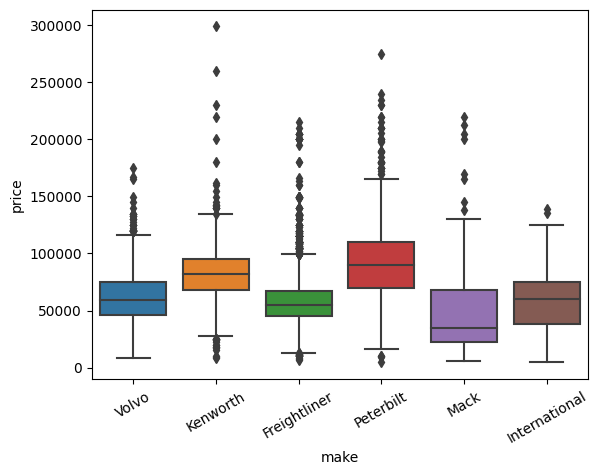

<Figure size 640x480 with 0 Axes>

In [23]:
sns.boxplot(data, x='make', y='price')
plt.xticks(rotation=30)
plt.show()
plt.clf()
    

Freightliner is showing 57% of the used truck market, whereas Mack is only showing 2%

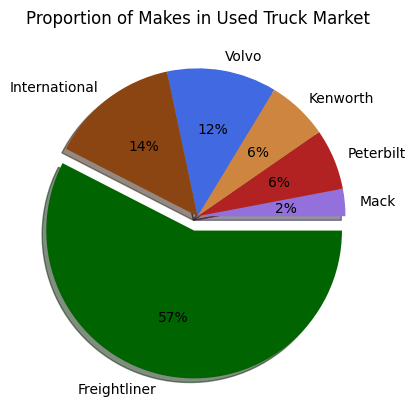

<Figure size 640x480 with 0 Axes>

In [24]:
colors = ['mediumpurple','firebrick','peru','royalblue','saddlebrown','darkgreen']
make_table = data.pivot_table(index='make', values=['price'], aggfunc=['count'])
max_value = max(make_table['count', 'price'])
make_table.sort_values(by=('count', 'price'), inplace=True)
explode_values = [.1 if count == max_value else 0 for count in make_table['count', 'price']]
plt.pie(make_table['count', 'price'], autopct='%d%%', labels = list(make_table.index), colors=colors, shadow=True, explode=explode_values)
plt.title('Proportion of Makes in Used Truck Market')
plt.show()
plt.clf()

#### Statistics by Dealer <a class="anchor" id="section3_2"></a>

Using a pivot table we are able to see that Penseke Used Trucks dealer has the most used trucks for sale

In [25]:
dealer_table = data.pivot_table(index='dealer', values=['mileage', 'price'], aggfunc=['count', 'mean'])
dealer_table.sort_values(by=('count', 'mileage'), ascending=False, inplace=True)
dealer_table.head()

count                 mean              
                           mileage price        mileage         price
dealer                                                               
Penske Used Trucks            2233  2233  512471.930587  54963.488580
Ryder Systems Inc             1605  1605  458075.758879  52574.246106
Arrow Truck Sales              692   692  513335.580925  74233.810694
Don Baskin Truck Sales LLC     633   633  576219.375987  27016.587678
Schneider                      506   506  559705.007905  56016.996047

using a different sorting method we can see that G&J Truck Sales Inc has the lowest average price of all the dealerships; however, the average mileage for a truck there is around 785,314 this is on the high side which might explain the low price.

In [26]:
dealer_table.sort_values(by=('mean', 'price'), ascending=True, inplace=True)
dealer_table.head()

count                 mean              
                              mileage price        mileage         price
dealer                                                                  
G&J Truck Sales Inc                89    89  785314.606742  21277.505618
Wieland Truck Sales Inc             2     2  626059.500000  21900.000000
Don Baskin Truck Sales LLC        633   633  576219.375987  27016.587678
Brookside Equipment Sales Inc      13    13  388304.461538  34765.384615
Boom & Bucket                       4     4  355638.000000  38871.250000

We comfirm this by sorting by highest mileage and G&J once again is our top.

In [27]:
dealer_table.sort_values(by=('mean', 'mileage'), ascending=False, inplace=True)
dealer_table.head()

count                 mean              
                        mileage price        mileage         price
dealer                                                            
G&J Truck Sales Inc          89    89  785314.606742  21277.505618
Reitzel Tractor, LLC          1     1  742000.000000  67500.000000
Martins Peterbilt            13    13  672403.692308  83446.153846
TSI Truck Sales               9     9  650492.333333  53577.777778
Diamond Trail Sales Inc       9     9  642244.555556  40722.222222

We use numpys `median` and `std` function to check the `median` values. We are looking for the best overall dealer where the `price` and `mileage` aren't too much or too little

In [28]:
median_mileage = np.median(dealer_table['mean', 'mileage'])
median_price = np.median(dealer_table['mean', 'price'])
std_mileage = np.std(dealer_table['mean', 'mileage'])
std_price = np.std(dealer_table['mean', 'price'])
print(f'the median mileage is: {median_mileage} with a standard deviation of {std_mileage}')
print(f'the median price is: {median_price} with a standard devation of {std_price}')


the median mileage is: 468084.3692307692 with a standard deviation of 118656.70104156462
the median price is: 76346.42857142858 with a standard devation of 26723.142320503135


We now plot our data along with the `median mileage` and price and we are going to draw a circle equal to 1 standard deviation from our `median`s. This will visually show us where we will consider our best chance for a decent used truck that limits risk of overpaying as well as possibly buying cheap and getting a bad quality truck.

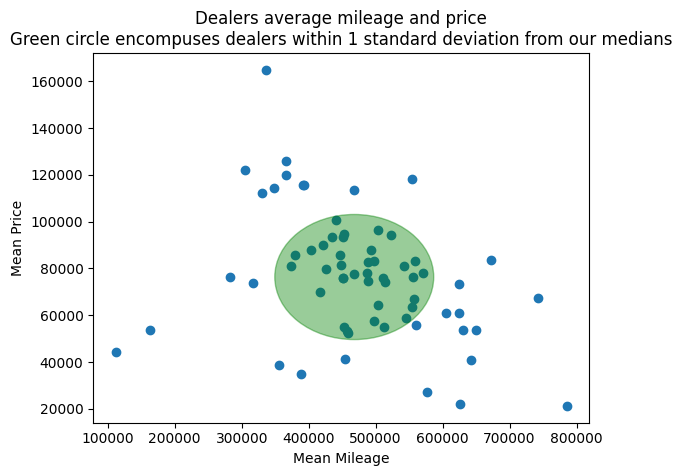

In [29]:
from matplotlib import patches

plt.scatter(dealer_table['mean', 'mileage'], dealer_table['mean', 'price'])
ellipse_1std = patches.Ellipse((median_mileage,median_price), width=std_mileage*2, height=std_price*2, fill=True, color='g', alpha=.4)
plt.gca().add_patch(ellipse_1std)
plt.xlabel('Mean Mileage')
plt.ylabel('Mean Price')
plt.title('Dealers average mileage and price\nGreen circle encompuses dealers within 1 standard deviation from our medians')
plt.show()


Now to get those dealers into a dataframe we get the outer variables of our `mileage` and `price` using the standard deviation. Then filter those from the pivot table and return a list of all the dealers we have left, Then we filter the original dataset to only include those dealers.
Here we have printed out all the fair dealers, if a Person was interested in used truck these would be the dealers recommended.

In [30]:
most_mileage = round(median_mileage + std_mileage, 2)
least_mileage = round(median_mileage - std_mileage, 2)
most_price = round(median_price + std_price, 2)
least_price = round(median_price - std_price, 2)
#print(f'mileage: {least_mileage} - {most_mileage}')
#print(f'price: {least_price} - {most_price}')

fair_table = dealer_table[dealer_table['mean','mileage'].between(least_mileage, most_mileage)]
fair_table = fair_table[fair_table['mean', 'price'].between(least_price, most_price)]
fair_dealer_list = list(fair_table.index)

fair_dealers = data[data['dealer'].isin(fair_dealer_list)]

print(fair_dealer_list)


['SelecTrucks of Alabama/Birmingham Freightliner', 'Schneider', 'Thompson Truck Center', 'Dobbs Peterbilt - CA', 'Trevs Trucks', 'Diamond Truck Sales Inc', 'Impex Heavy Metal', 'SelecTrucks of Atlanta', 'Wichita Kenworth', 'Arrow Truck Sales', 'Penske Used Trucks', 'IState Truck Center', 'Jordan Truck Sales of Texas LLC', 'Capital Volvo Truck & Trailer', 'J&B Pavelka Inc', 'Dobbs Peterbilt', 'Bruckner Truck Sales', 'Kenworth of Louisiana', 'Dobbs Peterbilt - WA', 'Tri-State Truck Center Inc', 'Western Truck Center of West Sacramento', 'Ryder Systems Inc', 'Truck and Van Outlet', "Bergey's Truck Centers", 'Quad-City Peterbilt, Inc', 'TransChicago Truck Group', 'The House of Trucks', 'Freightliner of Grand Rapids', 'WE Sales', 'JX Truck Center', 'Doggett Freightliner', 'M&K Truck Centers', 'Bonander Truck & Trailer', 'Rush Truck Centers', 'West Michigan International', 'Impel Union', 'CSM Companies, Inc.', 'International Used Truck Center']


#### Statistics by Year <a class="anchor" id="section3_3"></a>

To check some statistics regarding the `year` we will create another pivot table that will `count` how many trucks are in that year and another column that will take the average `price` of all the trucks in that `year`. we call `barplot` to visualize these

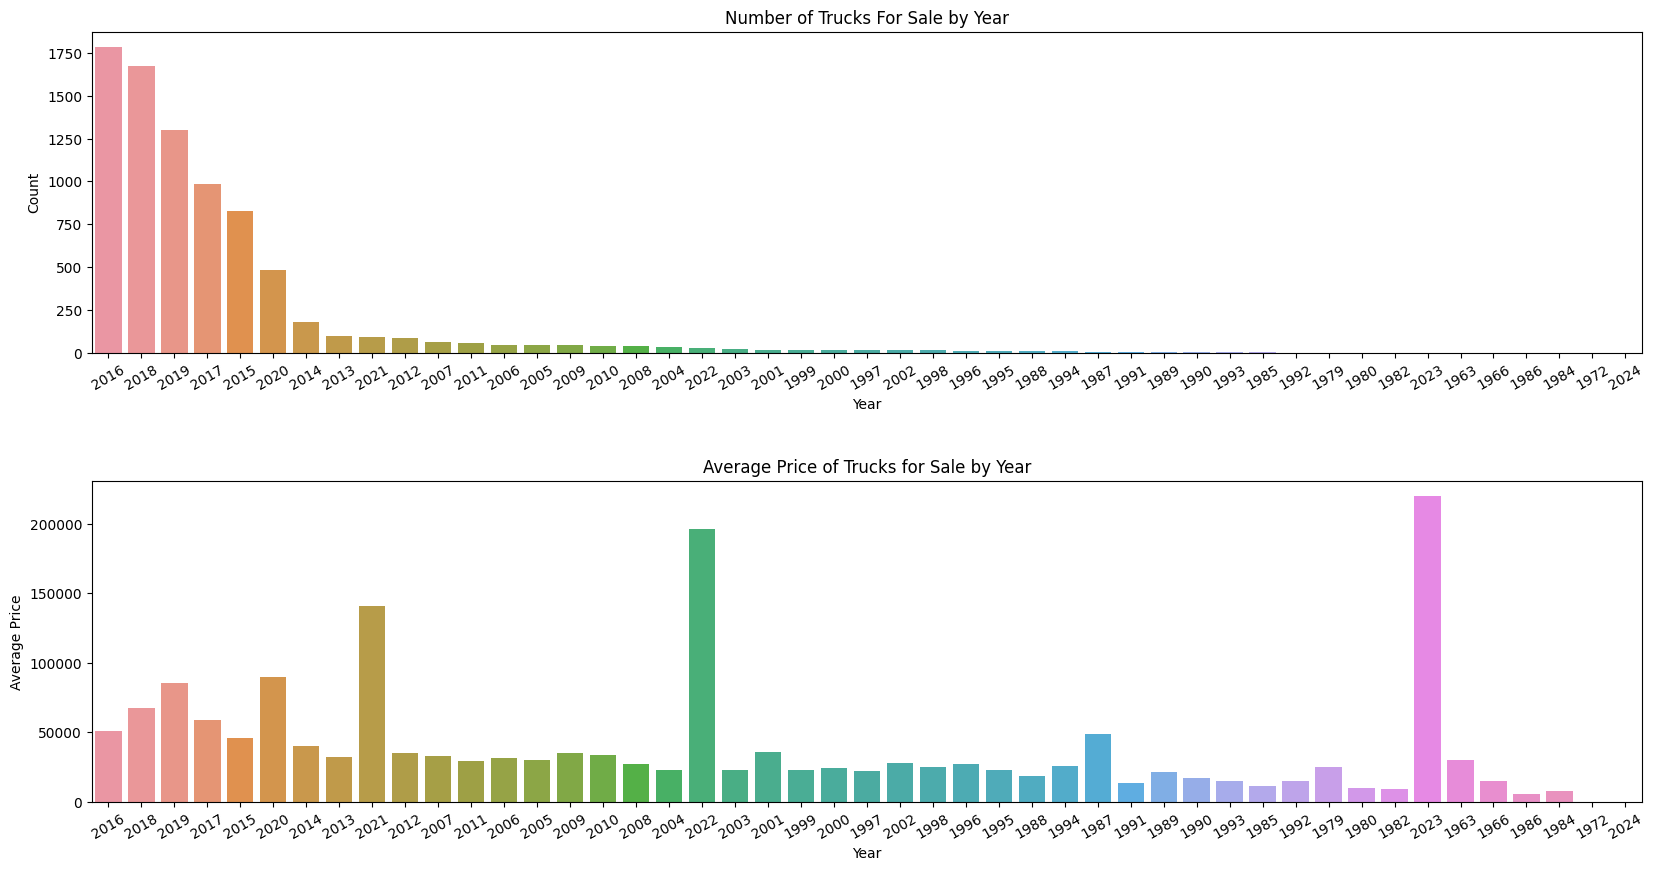

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.4)
plt.subplot(2,1,1)
year_table = data.pivot_table(index='year', values=['mileage', 'price'], aggfunc=['count', 'mean'])
year_table.sort_values(by=('count', 'price'), ascending= False, inplace=True)
sns.barplot(x=list(year_table.index), y=year_table['count', 'mileage'], data=year_table)
plt.title('Number of Trucks For Sale by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=30)

plt.subplot(2,1,2)
sns.barplot(x=list(year_table.index), y=year_table['mean', 'price'], data=year_table)
plt.title('Average Price of Trucks for Sale by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=30)
plt.show()
plt.clf()

### Prediction using a Simple Linear Model <a class="anchor" id="linear"></a>

There are a lot of outliers in our data and seeing how there is a significant drop in value of a truck after initial purchase we will do our best with Linear Regression. I will make a predictive model based on the `mileage` and `price` of the data we have.

Here we have created a linear regression predictive model that will predict what `price` a vehicle should be at when give then `mileage` there are 7 different models here one for each unique `make` of the vehicle.

Assumptions for Linear Regression
* Linear function form must have a clear linear relationship - this is not entirely as we can see 
* Normality should show a normally distributed histogram - some are showing scewed
* Homoscedacticity should be symmetrically scattered around 0 - most show signs of funnelling

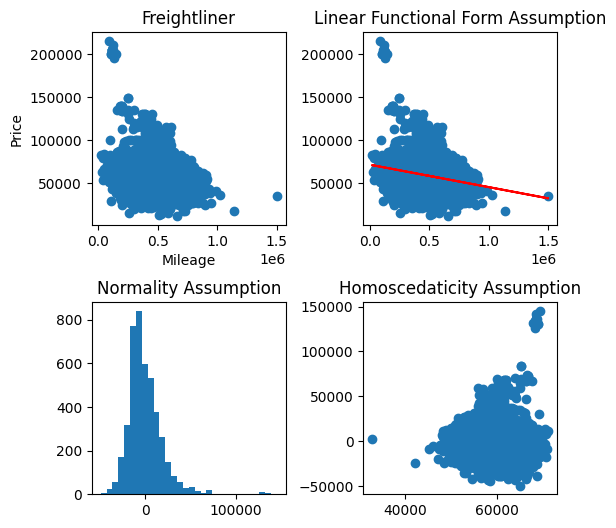

<Figure size 640x480 with 0 Axes>

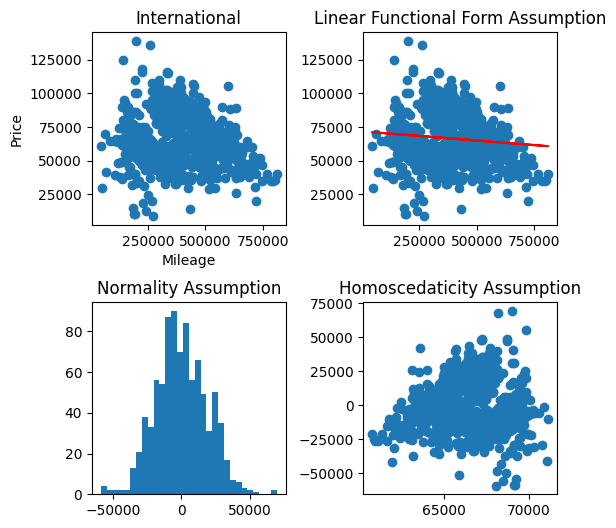

<Figure size 640x480 with 0 Axes>

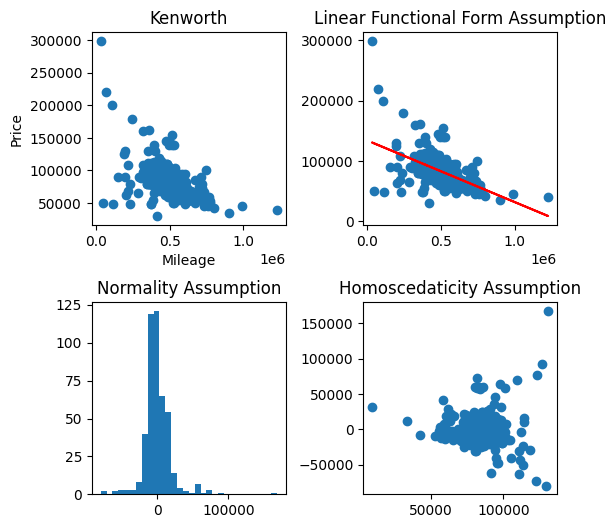

<Figure size 640x480 with 0 Axes>

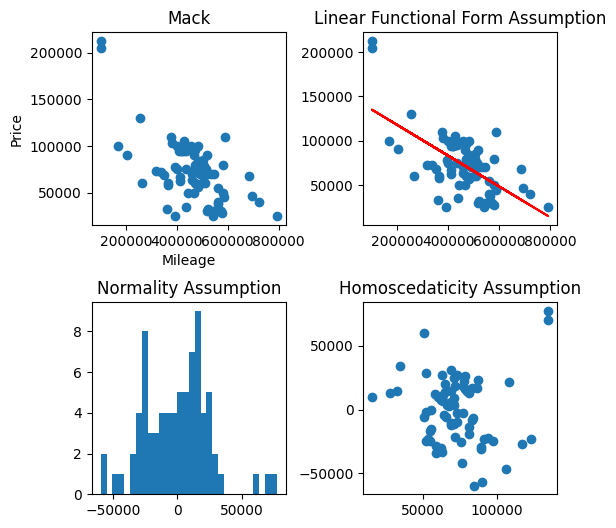

<Figure size 640x480 with 0 Axes>

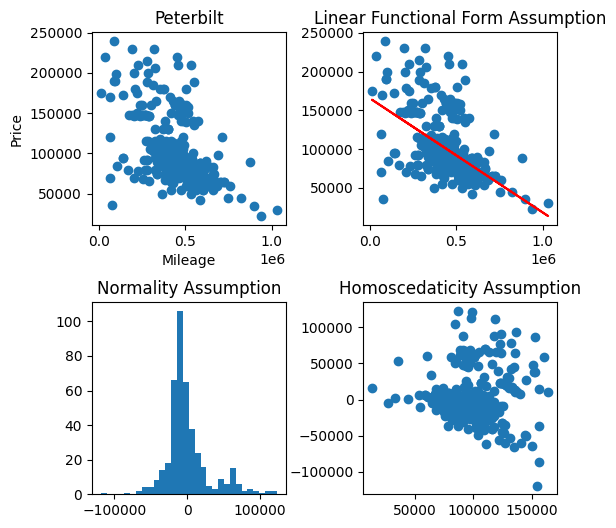

<Figure size 640x480 with 0 Axes>

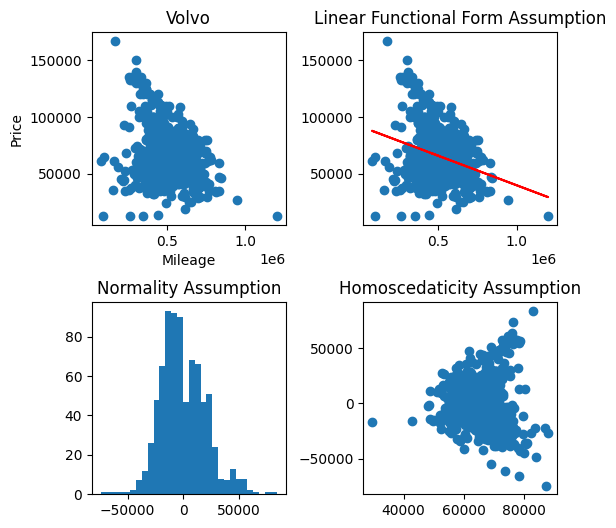

<Figure size 640x480 with 0 Axes>

In [32]:
import statsmodels.api as sm

# mileage we will use for testing
mileage_to_predict = 250000

# function to create and plot model
# data we will use, mileage we wish to use in our prediction, data_category to differentiate between sampled data
# plot so we have a choice on whether to plot or not
def predictive_model_mileage_to_price(df, mileage, data_category, plot=False):
    all_predictions = []
    for make in sorted(df['make'].unique()):
        # creating model
        oem = df[df['make'] == make]
        model = sm.OLS.from_formula('price ~ mileage', oem)
        results = model.fit()

        fitted_values = results.predict(oem)
        residuals = oem['price'] - fitted_values

        # all plots
        if plot:
            plt.figure(figsize=(6,6))
            plt.subplots_adjust(hspace=.4, wspace=.4)
            plt.subplot(2,2,1)
            y = results.params[1]* oem['mileage'] + results.params[0]
            plt.scatter(oem['mileage'], oem['price'])
            plt.xlabel('Mileage')
            plt.ylabel('Price')
            plt.title(make)
            
            plt.subplot(2,2,2)
            plt.scatter(oem['mileage'], oem['price'])
            y = results.params[1]* oem['mileage'] + results.params[0]
            plt.plot(oem['mileage'], y, color='red')
            plt.title('Linear Functional Form Assumption')

            plt.subplot(2,2,3)
            plt.hist(residuals, bins=30)
            plt.title('Normality Assumption')

            plt.subplot(2,2,4)
            plt.scatter(fitted_values, residuals)
            plt.title('Homoscedaticity Assumption')
            plt.show()
            plt.clf()

        # creating prediction based on mileage
        info = {'price': mileage}
        prediction = results.predict(info)

        # appending prediction to list 
        all_predictions.append([data_category, make, round(prediction[0], 2)])

    # creating dataframe to return    
    df = pd.DataFrame(all_predictions, columns=['data_category', 'make', 'price'])

    return df

df_250k = predictive_model_mileage_to_price(fair_dealers, mileage_to_predict, 'original', True)

#### Creating Sample Distribution <a class="anchor" id="section4_1"></a>

We will resolve these possible issue in our model by creating a sampling distribution from our data
* We will take 500 samples of each `make`
* Each sample will be the average `mileage` and average `price` from 30 random samples in our data.

In [33]:
# This function will take about 20s to complete

def create_sampling_dist_df(data):
    sample_size = 30
    averages = []

    # Loops through each unique make
    for make in data['make'].unique():
        # creating population
        population = data[data['make'] == make]

        # final data will have 500 samples
        for i in range(500):
            makes_list = []

            # randomly selecting an index from population and adding that row to a list, then converting to dataframe
            sample_indexes = np.random.choice(population.index, sample_size, replace=False)
            makes_list.extend([(data.loc[index]) for index in sample_indexes])
            makes_df = pd.DataFrame([make for make in makes_list], columns=data.columns)

            # Getting averages of the 30 samples then adding them to the final list with what make it is
            average_mileage = np.mean(makes_df['mileage'])
            average_price = np.mean(makes_df['price'])
            averages.extend([[make, average_mileage, average_price]])

    # creating dataframe of sample to return
    df = pd.DataFrame([row for row in averages], columns=['make', 'mileage', 'price'])
    return df

sample_data = create_sampling_dist_df(data)


Now we have a predictive model based of our sample data and we will put some data on it with our predicted mileage

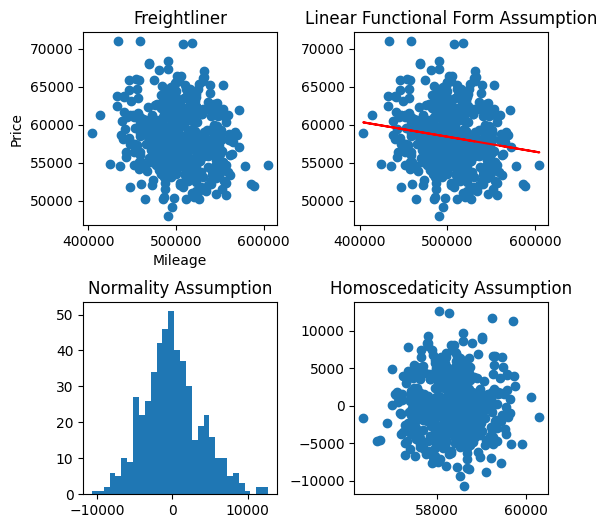

<Figure size 640x480 with 0 Axes>

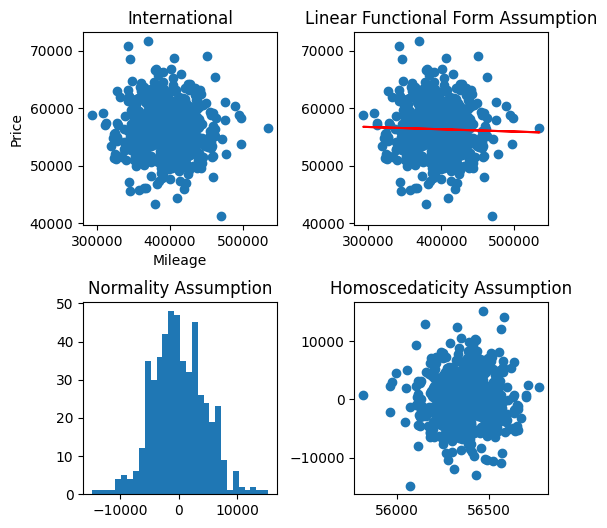

<Figure size 640x480 with 0 Axes>

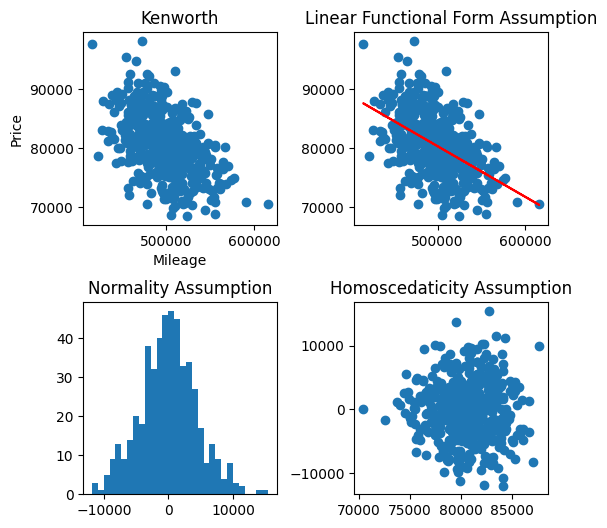

<Figure size 640x480 with 0 Axes>

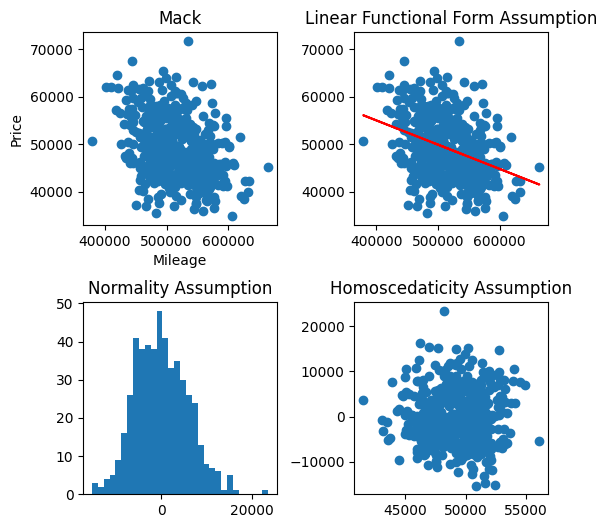

<Figure size 640x480 with 0 Axes>

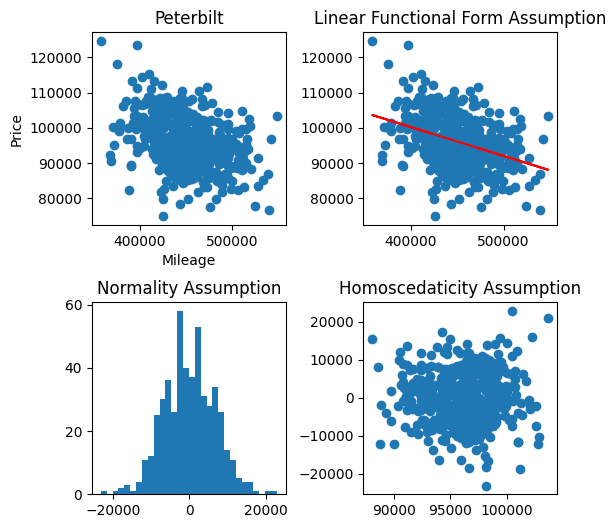

<Figure size 640x480 with 0 Axes>

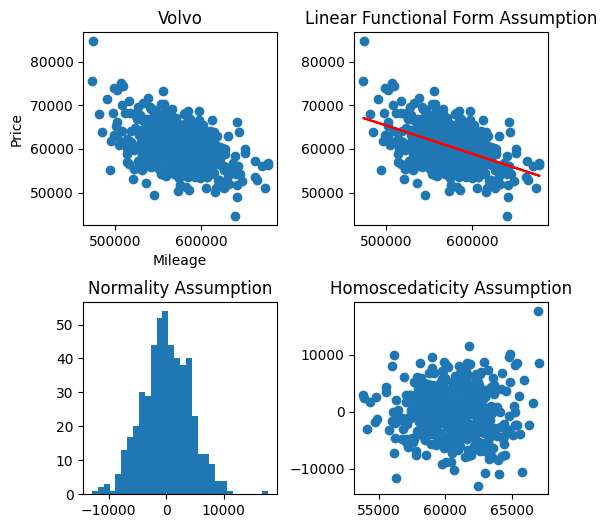

<Figure size 640x480 with 0 Axes>

In [34]:
# calling predictive model with sample 
df_sample_250k =  predictive_model_mileage_to_price(sample_data, mileage_to_predict, 'sample', True)

Next we will compare the difference from our orignal model from our sample model and see if they made any difference at all.

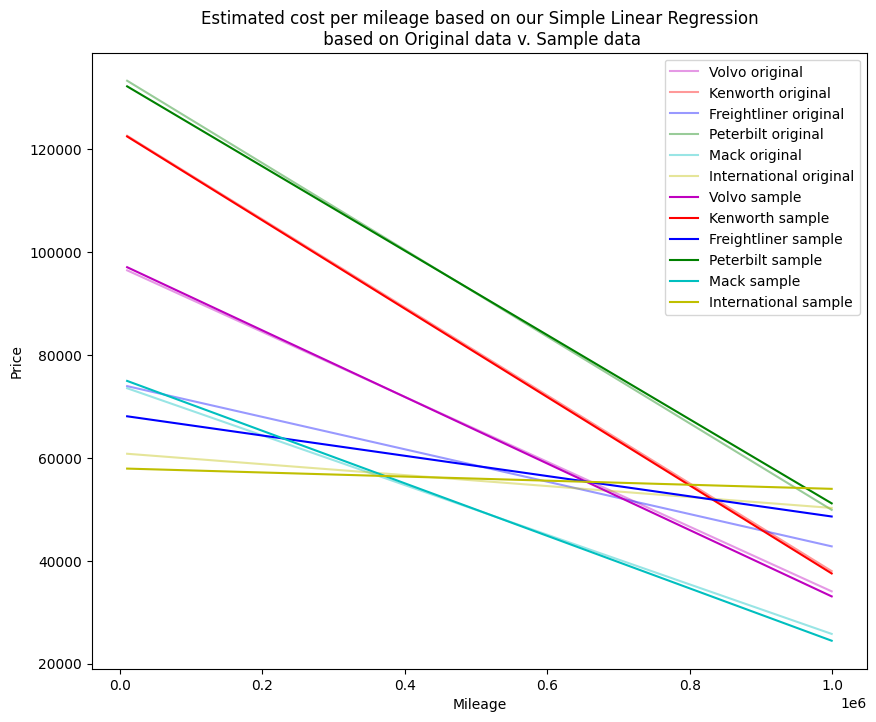

In [36]:
#will take 50s to generate
plt.figure(figsize=(10,8))

def plot_all_predictions(data, data_category):
    mileages = range(10000,1000000, 1000)
    colors = ['m','r','b','g','c','y']
    for i, make in enumerate(data['make'].unique()):
        makes_df =data[data['make']==make]
        makes_df_list = []
        for miles in mileages:
            makes_df_list.append(predictive_model_mileage_to_price(makes_df, miles, data_category))
        df = pd.concat(makes_df_list)
        df['mileage'] = mileages  
        if data_category == 'sample':
            plt.plot(df['mileage'], df['price'], label=make+ ' '+ data_category, color=colors[i])
        else:
            plt.plot(df['mileage'], df['price'], label=make+ ' '+ data_category, color=colors[i], alpha=.4)
    plt.legend()

plot_all_predictions(data, 'original')
plot_all_predictions(sample_data, 'sample')
plt.title('Estimated cost per mileage based on our Simple Linear Regression\n based on Original data v. Sample data')
plt.ylabel('Price')
plt.xlabel('Mileage')
plt.show()
   


### Conclusion: <a class="anchor" id="end"></a>
* Majority of trucks in the used truck market are Freightliners with a wopping 57% of our data, it could be that most of these trucks are either not being bought or a majority of people with freightliners are trying to sell their trucks. Either way, because of the high supply the cost of freightliners are very low compared to other makes - on the other side of the coin Macks are the least represented truck in our data with only 2%, theres not much data on these so our predictive model could not be very accurate for Mack trucks. The cause of this lack of data could be that not a lot of people are willing to sell their Mack trucks and the ones on the market are low price with high miles this reflects in our model.

* Majority of the Trucks for sale are 2016-2019 this makes sense as most trucks Standard Warranty end after 5 years This would indicate a trend that once a heavy duty truck is out of warranty the owners try and sell it and are most likely upgrading to newer models every 5 years

* There is a difference in the amount you will pay depending on the dealer you go to.

* Looking at the difference in our orginal data and sampled data all truck `make`s are right around the same except for one 'Peterbilt' this shows me that on average people who put there Peterbilt trucks for sale in the used truck market will want a very high amount and our model shows that they will want a lot more for what they have than what the data shows for it. Peterbilt also takes the biggest drop in value over the lifetime of the truck; however, if you were to buy it brand new and sell at low miles you could get the most money back for it. compared to Mack and Freightliner the used truck market will lose a lot of money compared to the oringal purchase price. A Freightliner with low mileage in the used truck market is only expected to be valued around 80k I would assume a new freightliner would be somewhere around 180k so it loses a lot of value but if you buy it used you we can predict that you should be able to put a lot of miles on it and be able to re-sale it for almost the same amount.